In [1]:
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from icecream import ic
from typing import Tuple, Any, List, Union, Literal

In [2]:
def make_probability(vector: np.ndarray) -> np.ndarray:
    """
    From the distribution dist, generate a probability vector that sums to 1. 
    """
    return vector / vector.sum()

In [3]:
class MultiArmBandit:
    """
    3-armed Bandit
    """    
    def __init__(self, prob1: np.ndarray, prob2: np.ndarray, prob3: np.ndarray, rewards: Union[List, np.ndarray]):
        self.prob1 = prob1
        self.prob2 = prob2
        self.prob3 = prob3
        self.rewards = rewards

        self.action_sequence = []
        self.reward_sequence = []
        self.cum_reward_sequence = []
        self.t = 0

        self.true_means = self.get_action_true_mean_rewards()

        self.optimal_action = np.argmax(self.true_means) + 1
        self.optimal_reward = np.max(self.true_means)


    def get_action_true_mean_rewards(self) -> List[float]:
        """
        Use probability distributions and reward values to calculate 
        true mean rewards for each action
        """
        mu1 = np.dot(self.rewards, self.prob1) 
        mu2 = np.dot(self.rewards, self.prob2) 
        mu3 = np.dot(self.rewards, self.prob3) 

        return [mu1, mu2, mu3]
    

    def get_reward(self, prob: np.ndarray) -> int:
        """
        For a given probability vector, generate a reward. 
        """
        cumulative_prob = np.cumsum([0] + list(prob))

        u = stats.uniform.rvs(0, 1)
        for i in range(1, len(cumulative_prob)):
            if u < cumulative_prob[i]:
                return self.rewards[i-1]


    def pull_arm(self, action: Literal[1, 2, 3]) -> int:
        """
        For the given probability vectors and action, generate a reward. 
        """
        probs = [self.prob1, self.prob2, self.prob3]   # Probabilities of action 1, 2, and 3
        reward = self.get_reward(probs[action - 1])

        self.action_sequence.append(action)
        self.reward_sequence.append(reward)

        if not self.cum_reward_sequence:
            self.cum_reward_sequence.append(reward)
        else:
            self.cum_reward_sequence.append(self.cum_reward_sequence[-1] + reward)

        self.t += 1

        return reward
    

    def calculate_cumulative_regret(self) -> np.ndarray:
        """
        Calculate the cumulative regret for the action sequence. 
        """
        true_mean_rewards_by_action = [self.true_means[a - 1] for a in self.action_sequence]
        instantaneous_regrets = [(self.optimal_reward - true_mean) for true_mean in true_mean_rewards_by_action]
        cumulative_regret = np.cumsum(instantaneous_regrets)

        return cumulative_regret

    
def random_action() -> int:
    """
    Generate a random action (integer) in the range [1, 3].
    """
    return np.random.randint(1, 4)
    

def explore_then_commit(action_sequence: List[int], reward_sequence: List[int], exploration_len: int) -> int:
    """
    Using the Explore-Then-Commit algorithm, generate the next output action 
    given the action sequence, reward sequence, and length of exploration. 
    """

    if len(action_sequence) <= 3 * exploration_len:
        next_action = len(action_sequence) % 3 + 1
    else:
        # Calculate the empirical mean reward for each action for the exploration phase
        exploration_actions = np.array(action_sequence)[:3 * exploration_len]
        exploration_rewards = np.array(reward_sequence)[:3 * exploration_len]
        # Get reward_sequence where action = 1
        mu1_hat = np.mean(exploration_rewards[exploration_actions == 1]) 
        # Get reward_sequence where action = 2
        mu2_hat = np.mean(exploration_rewards[exploration_actions == 2]) 
        # Get reward_sequence where action = 3
        mu3_hat = np.mean(exploration_rewards[exploration_actions == 3]) 

        next_action = np.argmax([mu1_hat, mu2_hat, mu3_hat]) + 1
    
    return next_action


def get_optimum_exploration_len(prob1: np.ndarray, prob2: np.ndarray, prob3: np.ndarray, rewards: Union[List, np.ndarray], horizon: int):
    """
    Calculate optimal exploration length based on reward distributions and horizon. 
    """
    # Calculate delta as the difference between the best and the second best arms
    # mu = E[X_t] = Sum(X_t * P(X_t))
    action1_true_mean = np.dot(rewards, prob1) 
    action2_true_mean = np.dot(rewards, prob2) 
    action3_true_mean = np.dot(rewards, prob3) 

    # Calculate the suboptimality gap
    true_means = [action1_true_mean, action2_true_mean, action3_true_mean]
    idx = np.argsort(true_means)
    sorted_means = np.array(true_means)[idx]
    delta = sorted_means[2] - sorted_means[1]

    T = horizon
    R = max(rewards) - min(rewards)
    delta_sq = delta ** 2
    R_sq = R ** 2
    log_term = (2 * T * delta_sq)/R_sq
    coeff = (R_sq / (2 * delta_sq))
    
    optimal_exploration_len = coeff * np.log(log_term)

    return math.ceil(optimal_exploration_len)

In [4]:
# Vector used to generate distribution
d1 = np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610])
prob1 = make_probability((d1 + d1[::-1])[:10])

# Vector used to generate distribution
d2 = np.histogram(np.random.normal(0, 4, 10000), bins=51)[0][5:15]
prob2 = make_probability(abs(d2))

prob3 = make_probability((d1 + d1[::-1])[3:13])

rewards = np.arange(1, 11)

params = {
    "prob1": prob1, 
    "prob2": prob2, 
    "prob3": prob3, 
    "rewards": rewards
}

T = 2000
etc_optimal_m = get_optimum_exploration_len(horizon=T, **params)
etc_optimal_m

96

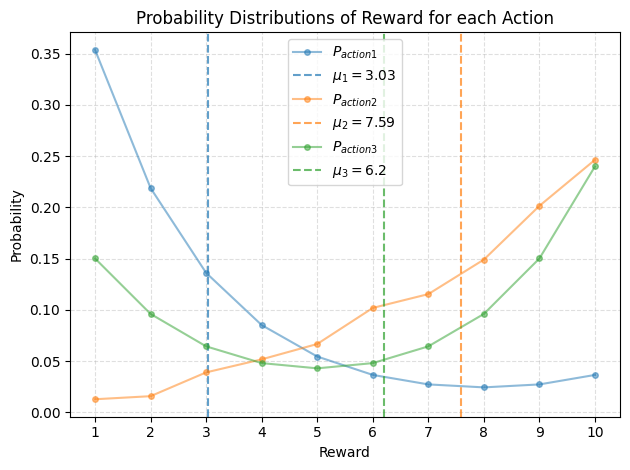

In [5]:
# plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(1, 1)
line1, = ax.plot(rewards, prob1, label="$P_{action1}$", alpha=0.5, marker="o", markersize=4)
mu1 = round(np.dot(prob1, np.arange(1, 11)), 2)
ax.axvline(mu1, label=f"$\mu_{1} = {mu1}$", ls="--", color=line1.get_color(), alpha=0.7)

line2, = ax.plot(rewards, prob2, label="$P_{action2}$", alpha=0.5, marker="o", markersize=4)
mu2 = round(np.dot(prob2, np.arange(1, 11)), 2)
ax.axvline(mu2, label=f"$\mu_{2} = {mu2}$", ls="--", color=line2.get_color(), alpha=0.7)

line3, = ax.plot(rewards, prob3, label="$P_{action3}$", alpha=0.5, marker="o", markersize=4)
mu3 = round(np.dot(prob3, np.arange(1, 11)), 2)
ax.axvline(mu3, label=f"$\mu_{3} = {mu3}$", ls="--", color=line3.get_color(), alpha=0.7)

ax.set_title("Probability Distributions of Reward for each Action")
ax.set_xlabel("Reward")
ax.set_ylabel("Probability")
ax.set_xticks([_ for _ in range(1, 11)])
ax.legend()
ax.grid(alpha=0.4, ls="--")
plt.tight_layout()
plt.show()

In [6]:
exploration_lens = [10, 100, 500, etc_optimal_m]

simulated_etc_bandits = dict()

for m in exploration_lens:
    # Create a new bandit for each exploration length. 
    etc_bandit = MultiArmBandit(**params)

    # For each exploration length (m), run the simulation for 
    # a horizon of T for the bandit. 
    for _ in range(T):
        etc_action = explore_then_commit(
            action_sequence=etc_bandit.action_sequence, 
            reward_sequence=etc_bandit.reward_sequence, 
            exploration_len=m
            )
        etc_bandit.pull_arm(etc_action)

    simulated_etc_bandits[m] = etc_bandit

In [7]:
# Simulate the random action choice bandit for a horizon T
random_choice_bandit = MultiArmBandit(**params)
for _ in range(T):
    random_choice_bandit.pull_arm(random_action())

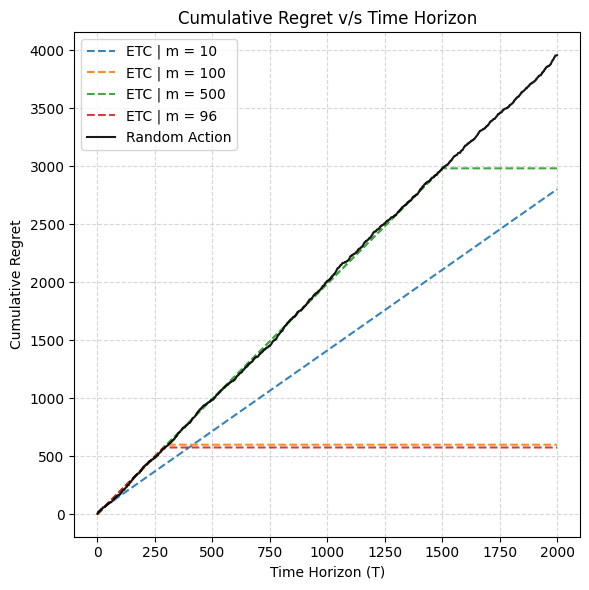

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for m, bandit in simulated_etc_bandits.items():
    etc_running_cum_regret = bandit.calculate_cumulative_regret()
    ax.plot(etc_running_cum_regret, label=f"ETC | m = {m}", alpha=0.9, ls="--")

random_running_cum_regret = random_choice_bandit.calculate_cumulative_regret()
ax.plot(random_running_cum_regret, label=f"Random Action", alpha=0.9, c="k")

ax.set_title("Cumulative Regret v/s Time Horizon")
ax.set_xlabel("Time Horizon (T)")
ax.set_ylabel("Cumulative Regret")
ax.grid(alpha=0.5, ls="--")
ax.legend()
plt.tight_layout()
plt.show()

From the above graph, we can see that the explore-then-commit algorithm's regret grows as the exploration length (M) grows relative to the time horizon (T). When exploring for M = 500, the regret is around 3000, where as that for M = 100 is around 650, which is just over that of the optimal exploration length (M*) of 96.  

Also, if we don't explore enough, the algorithm may commit to a sub-optimal arm, leading to regret which does not plateau during the exploitation phase. We see that the regret for m = 10 is much larger than that of M = 96, and conclude that we should explore for at least as long as M* to lower the chances of committing to the wrong action. 